In [2]:
import os
from os.path import join, exists, basename
from glob import glob
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import pandas as pd
import matplotlib
import copy
from scipy import interpolate
from scipy.signal import correlate2d
from sklearn.preprocessing import normalize
from rasterio.plot import show

In [3]:
df_2021 = pd.read_csv('../../data/wx_station/banner/312_STAND_YEAR=2021.csv', skiprows=3)
df_2020 = pd.read_csv('../../data/wx_station/banner/312_STAND_YEAR=2020.csv', skiprows=3)
df = df_2021.append(df_2020)
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')
df = df.sort_index()
df

Site Id   Time  WTEQ.I-1 (in)   PREC.I-1 (in)   TOBS.I-1 (degC)   \
Date                                                                           
2020-01-01      312  16:00             6.9             7.2              -2.4   
2020-01-01      312  23:00             6.8             7.2              -4.4   
2020-01-01      312  22:00             6.8             7.2              -4.3   
2020-01-01      312  21:00             6.8             7.2              -4.1   
2020-01-01      312  20:00             6.8             7.2              -4.3   
...             ...    ...             ...             ...               ...   
2021-10-29      312  02:00             2.5             4.7               0.1   
2021-10-29      312  01:00             2.5             4.7               0.5   
2021-10-29      312  00:00             2.5             4.7               1.0   
2021-10-29      312  10:00             2.6             4.8              10.0   
2021-10-29      312  20:00             2.5             4.7               3.6   

            SNWD.I-1 (in)   Unnamed: 7  
Date                                    
2020-01-01            30.0         NaN  
2020-01-01           -99.9         NaN  
2020-01-01           -99.9         NaN  
2020-01-01           -99.9         NaN  
2020-01-01           -99.9         NaN  
...                    ...         ...  
2021-10-29             8.0         NaN  
2021-10-29             8.0         NaN  
2021-10-29             8.0         NaN  
2021-10-29           -99.9         NaN  
2021-10-29             7.0         NaN  

[15993 rows x 7 columns]

In [4]:
df = pd.read_csv('../../data/wx_station/banner/312_STAND_YEAR=2021.csv', skiprows=3)
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')

data_dir = '../../../tmp/'
cor_fps = glob(join(data_dir, '*cor.grd.clip.ma.tiff'))
unw_fps = glob(join(data_dir, '*unw.grd.clip.ma.tiff'))
inc_fp = glob(join(data_dir, '*inc*'))[0]
sd_fp = glob(join(data_dir, '*snow_depth*'))[0]

unw_names = [basename(i).split('.')[0] for i in unw_fps]

date_dic = {'lowman_23205_21015-008_21017-018_0007d_s01_L090HH_01':['2021-03-03','2021-03-10'],
 'lowman_23205_20002-007_20007-003_0013d_s01_L090HH_01':['2020-01-31','2020-02-13'],
 'lowman_23205_20007-003_20011-003_0008d_s01_L090HH_01':['2020-02-13','2020-02-21'],
 'lowman_23205_21004-003_21008-000_0007d_s01_L090HH_01':['2021-01-20','2021-01-27'],
 'lowman_23205_21019-018_21021-006_0006d_s01_L090HH_01':['2021-03-16','2021-03-22'],
 'lowman_23205_21012-000_21015-008_0021d_s01_L090HH_01':['2021-02-10','2021-03-03'],
 'lowman_23205_20011-003_20016-004_0019d_s01_L090HH_01':['2020-02-21','2020-03-11'],
 'lowman_23205_21009-004_21012-000_0007d_s01_L090HH_01':['2021-02-03','2021-02-10'],
 'lowman_23205_21017-018_21019-018_0006d_s01_L090HH_01':['2021-03-10','2021-03-16'],
 'lowman_23205_19084-017_20002-007_0042d_s01_L090HH_01':['2019-12-20','2020-01-31']}
 
date_dic = {k:pd.to_datetime(v) for (k,v) in date_dic.items()}

In [5]:
cor_2021_fps = []
for fp in cor_fps:
    date = date_dic[basename(fp).split('.')[0]]
    if date[0] > pd.to_datetime('2021-01-01'):
        cor_2021_fps.append(fp)
unw_2021_fps = []
for fp in unw_fps:
    date = date_dic[basename(fp).split('.')[0]]
    if date[0] > pd.to_datetime('2021-01-01'):
        unw_2021_fps.append(fp)
unw_2020_fps = []
for fp in unw_fps:
    if fp not in unw_2021_fps:
        unw_2020_fps.append(fp)

# Snotel Check

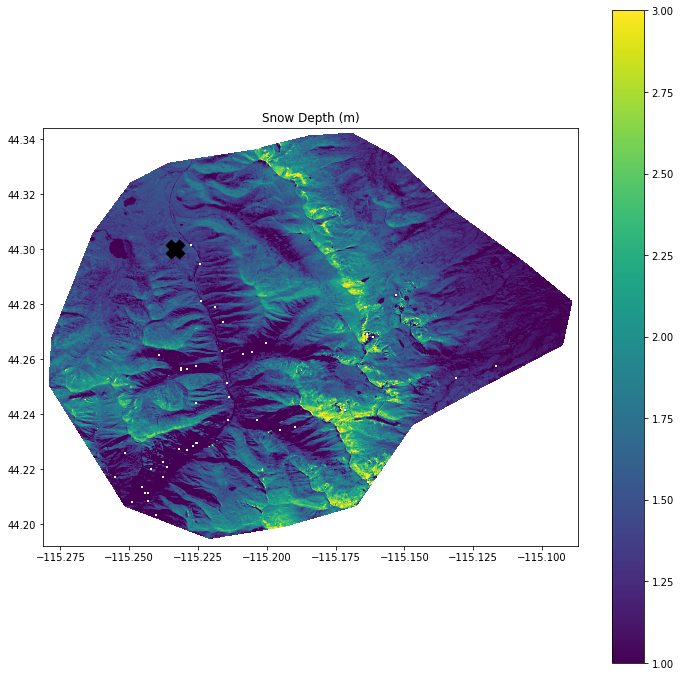

In [8]:
f, ax = plt.subplots(figsize = (12,12))
with rio.open(sd_fp) as sd, rio.open(inc_fp) as inc:
    # a = ax.imshow(sd.read(1), vmin =1, vmax = 3, )

    image = show(sd, ax = ax, vmin = 1, vmax = 3)
    im = image.get_images()[0]
    ax.scatter([-115.2333],[44.3], color = 'black', marker='x', linewidths = 20)
    sd = sd.read(1)
    inc = inc.read(1)
    inc[np.isnan(sd)] = np.nan
    f.colorbar(im, ax = ax)
    ax.set_title('Snow Depth (m)')

In [6]:
def epsilon_density(p):
    return 1 + 1.6*p + 1.8 * p**3
epsilon_density(.25)

def invert_sd(unw, inc, wavelength = 0.238403545, epsilon = 1.42):
    sd = - (unw * wavelength)/ (4 * np.pi) / (np.cos(inc) - np.sqrt(epsilon - (np.sin(inc)**2)))
    return sd
v_inversion = np.vectorize(invert_sd)

In [8]:
cor_2021_fps

['../../../tmp/lowman_23205_21015-008_21017-018_0007d_s01_L090HH_01.cor.grd.clip.ma.tiff',
 '../../../tmp/lowman_23205_21004-003_21008-000_0007d_s01_L090HH_01.cor.grd.clip.ma.tiff',
 '../../../tmp/lowman_23205_21019-018_21021-006_0006d_s01_L090HH_01.cor.grd.clip.ma.tiff',
 '../../../tmp/lowman_23205_21012-000_21015-008_0021d_s01_L090HH_01.cor.grd.clip.ma.tiff',
 '../../../tmp/lowman_23205_21009-004_21012-000_0007d_s01_L090HH_01.cor.grd.clip.ma.tiff',
 '../../../tmp/lowman_23205_21017-018_21019-018_0006d_s01_L090HH_01.cor.grd.clip.ma.tiff']

In [12]:
i = basename(unw_2021_fps[0]).split('.')[0]
[j for j in cor_2021_fps if i in j]

['../../../tmp/lowman_23205_21009-004_21012-000_0007d_s01_L090HH_01.cor.grd.clip.ma.tiff']


DatetimeIndex(['2021-02-03', '2021-02-10'], dtype='datetime64[ns]', freq=None)
0.11846273459121438


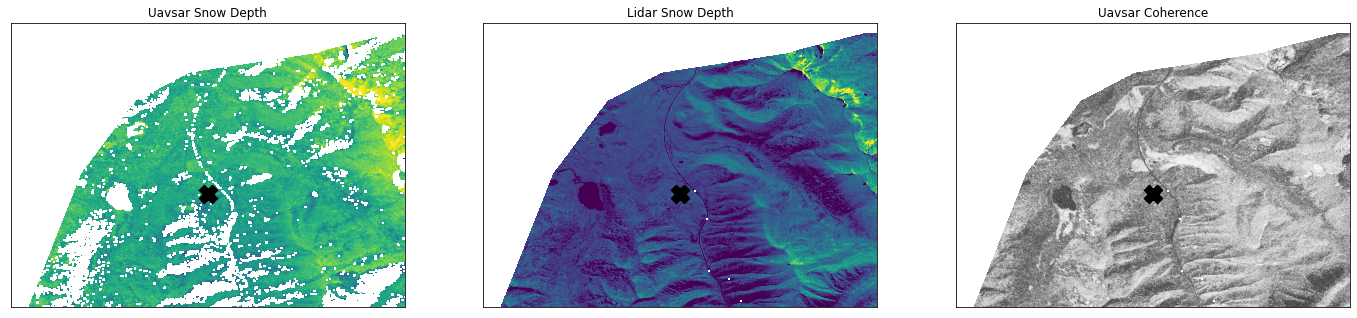


DatetimeIndex(['2021-03-03', '2021-03-10'], dtype='datetime64[ns]', freq=None)
0.01734109363826927


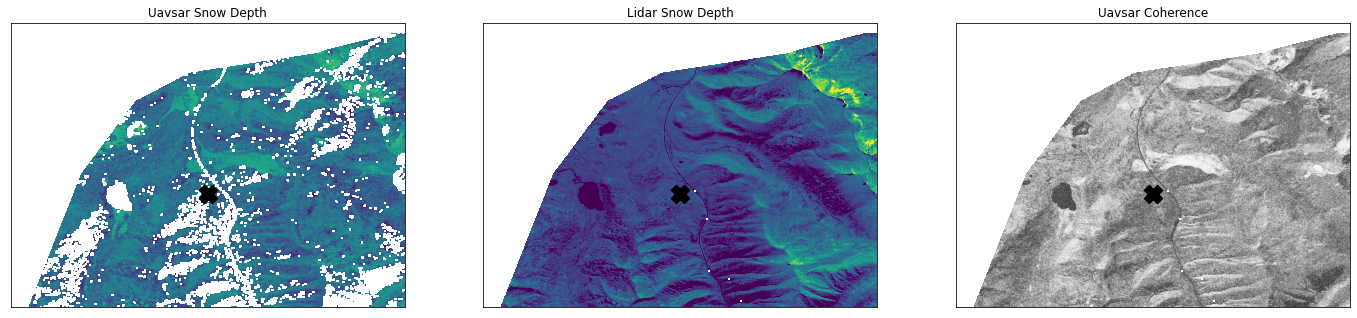


DatetimeIndex(['2021-03-16', '2021-03-22'], dtype='datetime64[ns]', freq=None)
nan


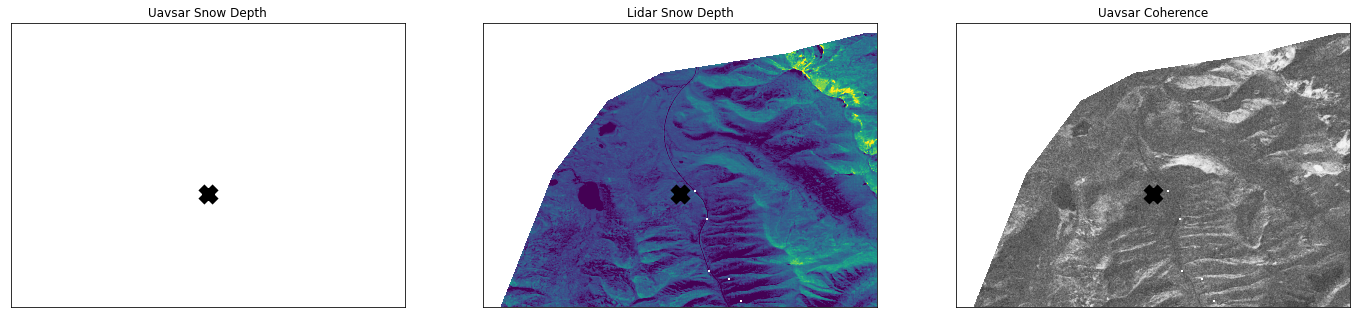


DatetimeIndex(['2021-01-20', '2021-01-27'], dtype='datetime64[ns]', freq=None)
0.006038589863218527


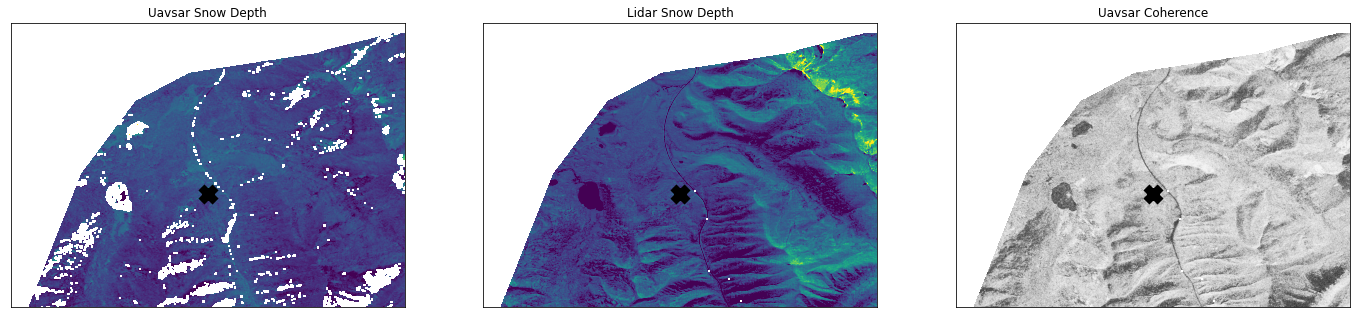


DatetimeIndex(['2021-03-10', '2021-03-16'], dtype='datetime64[ns]', freq=None)
-0.011996165846507223


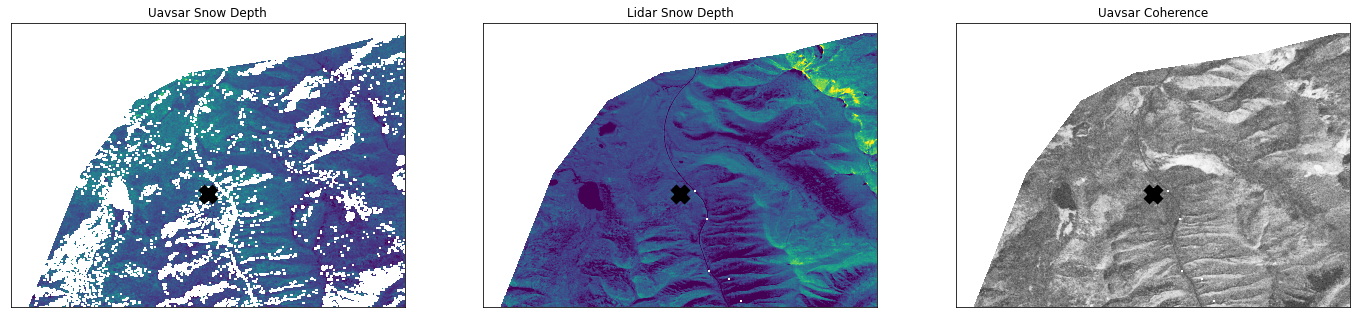

In [9]:
res = {}
for fp in unw_2021_fps:
    print()
    f, axes = plt.subplots(1,3, figsize = (24,36))
    i = basename(fp).split('.')[0]
    print(date_dic[i])
    cor_fp = [j for j in cor_2021_fps if i in j][0]
    with rio.open(fp) as unw:
        unw = unw.read(1)
    with rio.open(cor_fp) as cor:
        cor = cor.read(1)
    extent = [0,1300,0,1800]
    snotel_unw = unw[extent[0]+780, extent[2]+900]
    snotel_inc = inc[extent[0]+780, extent[2]+900]
    snotel_sd = invert_sd(snotel_unw, snotel_inc)
    print(snotel_sd)
    axes[0].imshow(unw[extent[0]:extent[1],extent[2]:extent[3]], vmin = -1, vmax = 3)
    axes[0].set_title('Uavsar Snow Depth')
    axes[1].imshow(sd[extent[0]:extent[1],extent[2]:extent[3]], vmin = 1, vmax = 3)
    axes[1].set_title('Lidar Snow Depth')
    axes[2].imshow(cor[extent[0]:extent[1],extent[2]:extent[3]], vmin = 0, vmax = 1, cmap = 'Greys_r')
    axes[2].set_title('Uavsar Coherence')
    for ax in axes:
        ax.scatter([900],[780], color = 'black', marker = 'x', linewidth = 20)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()
    
    res[fp] = snotel_sd

885
770


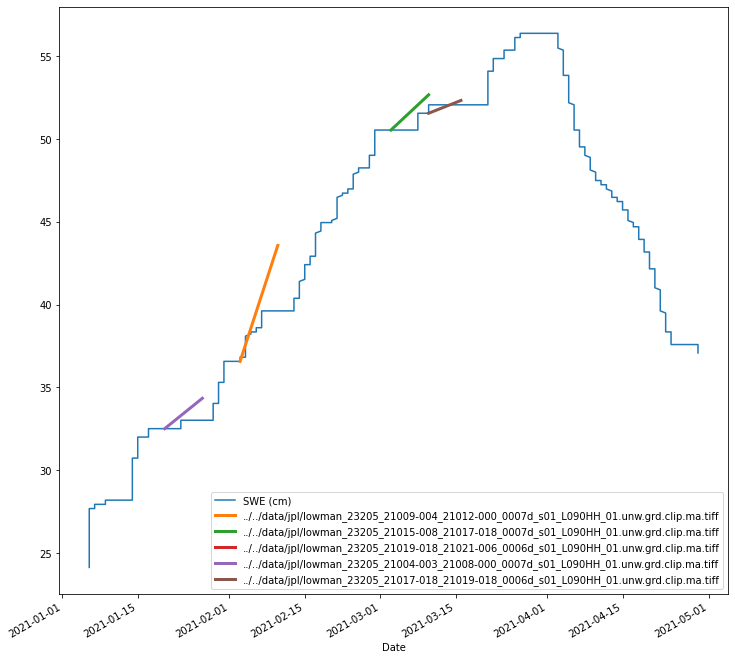

In [62]:
for x_loc in [885]:
    for y_loc in [770]:
        res = {}
        for fp in unw_2021_fps:
            with rio.open(fp) as unw:
                unw = unw.read(1)
            extent = [0,1300,0,1800]

            # x_loc = 901
            # y_loc = 781
            snotel_unw = unw[extent[0]+y_loc, extent[2]+x_loc]
            snotel_inc = inc[extent[0]+y_loc, extent[2]+x_loc]
            snotel_sd = invert_sd(snotel_unw, snotel_inc)
            # print(snotel_sd)
            res[fp] = snotel_sd

            if len([i for i in res.values() if not np.isnan(i)]) >3:
            
                a = df['WTEQ.I-1 (in) '][(df.index > pd.to_datetime('2021-01-01')) & (df.index < pd.to_datetime('2021-04-30'))].rolling(window = 100).median()
                a_m = a*0.0254*100
                a_m.plot(figsize = (12,12), label = 'SWE (cm)')
                i = 50
                for k, v in res.items():
                    dates = date_dic[basename(k).split('.')[0]]
                    if dates[0]>pd.to_datetime('2019-01-01'):
                        start_height = a_m[dates[0]].iloc[0]
                        end_height = start_height + 100 * v
                        plt.plot(dates, [start_height,end_height], linewidth = 3, label = k)
                plt.legend()
                print(x_loc)
                print(y_loc)
                plt.show()

0.01485875142750027
nan


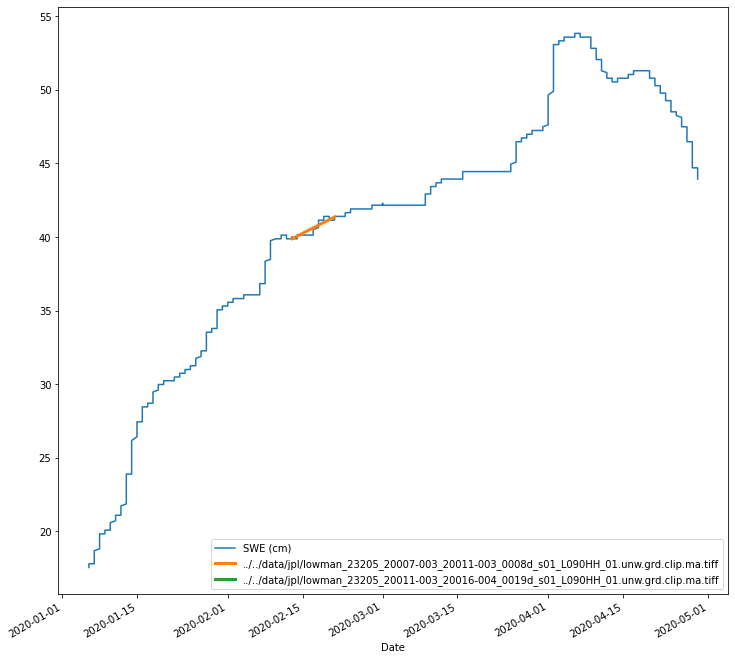

In [63]:
res = {}
for fp in unw_2020_fps:
    with rio.open(fp) as unw:
        unw = unw.read(1)
    extent = [0,1300,0,1800]
    snotel_unw = unw[extent[0]+780, extent[2]+885]
    snotel_inc = inc[extent[0]+780, extent[2]+885]
    snotel_sd = invert_sd(snotel_unw, snotel_inc)
    print(snotel_sd)
    res[fp] = snotel_sd
    
a = df['WTEQ.I-1 (in) '][(df.index > pd.to_datetime('2020-01-01')) & (df.index < pd.to_datetime('2020-04-30'))].rolling(window = 100).median()
a_m = a*0.0254*100
a_m.plot(figsize = (12,12), label = 'SWE (cm)')
i = 50
for k, v in res.items():
    dates = date_dic[basename(k).split('.')[0]]
    if dates[0]>pd.to_datetime('2019-01-01'):
        start_height = a_m[dates[0]].iloc[0]
        end_height = start_height + 100 * v
        plt.plot(dates, [start_height,end_height], linewidth = 3, label = k)
plt.legend()

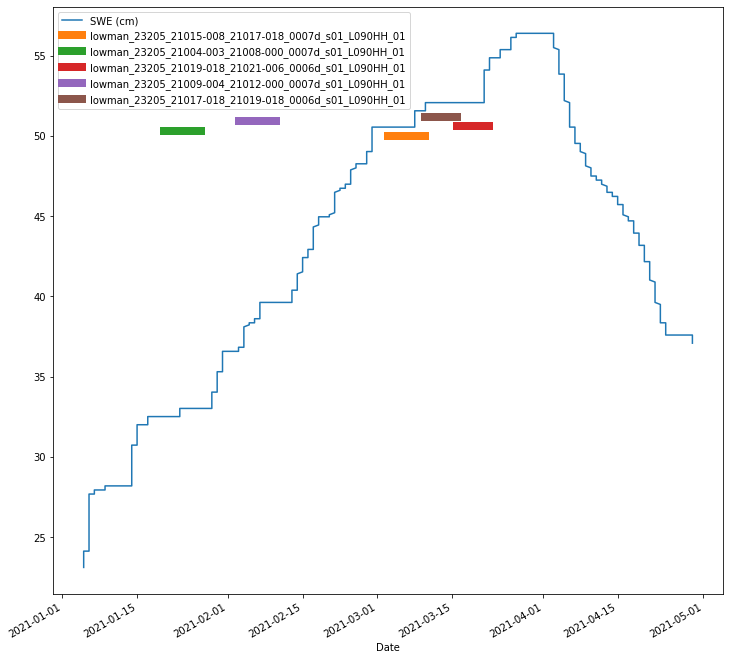

In [27]:
a = df['WTEQ.I-1 (in) '][df.index < pd.to_datetime('2021-04-30')].rolling(window = 100).median()
a_m = a*0.0254*100
a_m.plot(figsize = (12,12), label = 'SWE (cm)')
i = 50
for k, v in date_dic.items():
    if v[0]>pd.to_datetime('2021-01-01') and k in unw_names:
        
        plt.plot(v, [i,i], linewidth = 8, label = k)
        i +=0.3
plt.legend()

# Avi Search

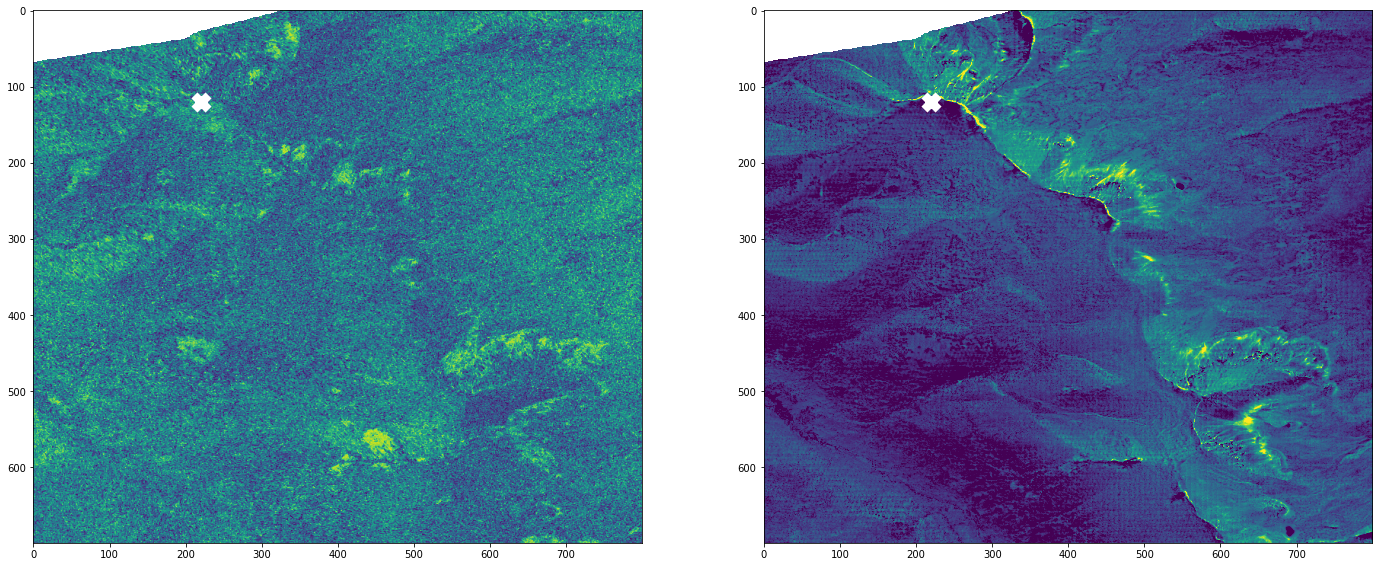

In [81]:
f, axes = plt.subplots(1,2, figsize = (24,36))
with rio.open(cor_2021_fps[3]) as coh:
    coh = coh.read(1)
extent = [100,800,1200,2000]
axes[0].imshow(coh[extent[0]:extent[1],extent[2]:extent[3]], vmin = 0, vmax = 1)
axes[1].imshow(sd[extent[0]:extent[1],extent[2]:extent[3]], vmin = 1, vmax = 4)
for ax in axes:
    ax.scatter([220],[120], color = 'white', marker = 'x', linewidth = 20)

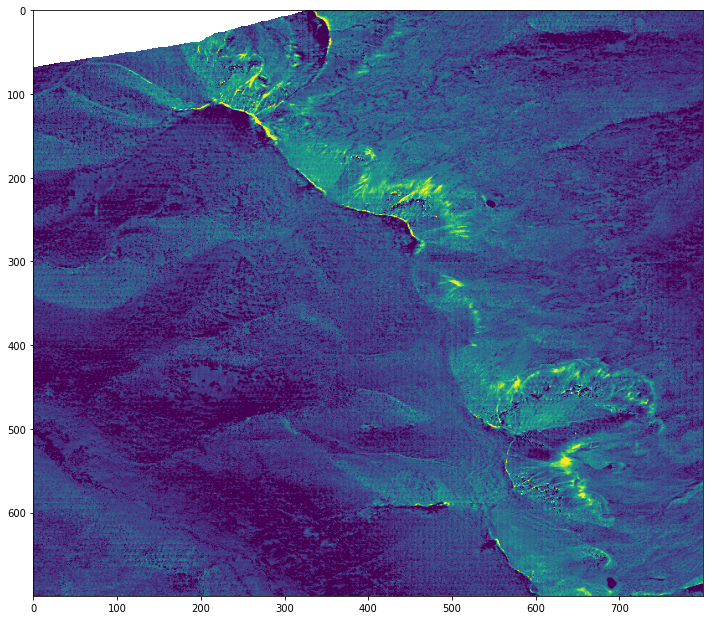

In [53]:
f, ax = plt.subplots(figsize = (12,12))
extent = [100,800,1200,2000]
plt.imshow(sd[extent[0]:extent[1],extent[2]:extent[3]], vmin = 1, vmax = 4)

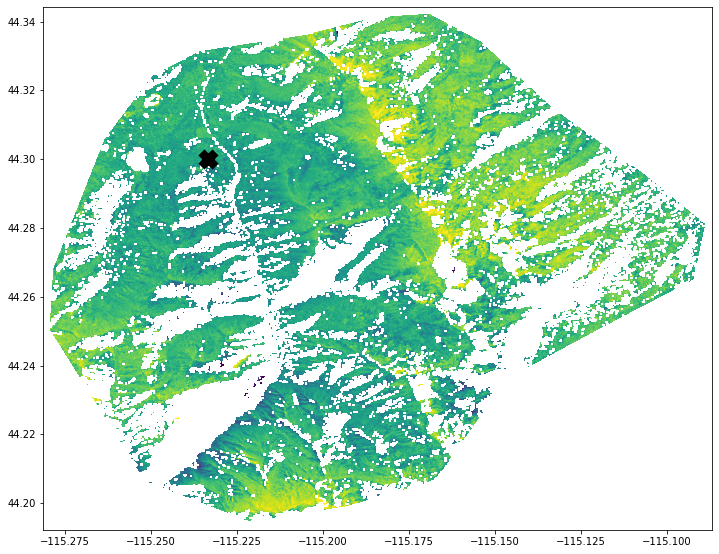

In [6]:
f, ax = plt.subplots(figsize = (12,12))
with rio.open(unw_fps[0]) as unw:
    show(unw, ax = ax, vmin = -1, vmax = 3)
    ax.scatter([-115.2333],[44.3], color = 'black', marker='x', linewidths = 20)
    unw = unw.read(1)